### 总结：Quantum Variational Autoencoder（QVAE）原理与代码实现

---

## 一、QVAE 原理概括

QVAE（Quantum Variational Autoencoder）是一种将 **量子生成模型** 引入 **变分自编码器(VAE)** 潜空间的生成模型。其核心思想是：

> **用量子玻尔兹曼机（QBM）替代传统VAE中的先验分布，从而构建一个具有量子生成能力的潜变量模型。**

### 模型结构

QVAE 包括以下关键组件：

1. **编码器（Encoder）**：  
   将输入数据 x 映射为潜变量的近似后验分布  
   $q_\phi(z|x)$，通常由神经网络参数化。

2. **先验分布（Prior）**：  
   使用 **量子玻尔兹曼机(QBM)** 建模潜变量 z 的先验分布。哈密顿量为：  
   $$
   \mathcal{H}_\theta = \sum_l \Gamma_l \sigma_l^x + \sum_l h_l \sigma_l^z + \sum_{l<m} W_{lm} \sigma_l^z \sigma_m^z
   $$

3. **解码器（Decoder）**：  
   将潜变量 z（或其连续松弛变量 $\zeta$）映射回数据空间，并使用解码器重建原始数据：  
   $$
   p_\theta(\mathbf{x} | \boldsymbol{\zeta}) \approx \text{Bernoulli}(f_\theta(\boldsymbol{\zeta}))
   $$

### 训练目标：Q-ELBO

QVAE 使用一个 **量子下界(Q-ELBO)** 来近似最大化对数似然：

$$
\mathcal{L}_{\text{Q-ELBO}} = \mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})} [\log p_\theta(\mathbf{x} | \boldsymbol{\zeta})] - \tilde{H}(q_\phi(\mathbf{z}|\mathbf{x}) \| p_\theta(\mathbf{z}))
$$

### QBM采样与训练

- **正相（positive phase）**：从编码器采样  $z \sim q_\phi(z|x)$
- **负相（negative phase）**：从 QBM 中采样 $z \sim p_\theta(z)$，使用 **蒙特卡洛方法** 或 **量子退火器**
把能量作为目标函数，objective的梯度即为基于正相和负相采样计算的梯度

## 二、代码架构概述

```bash

QVAE 完整训练流程
│
├── 1. 数据准备 (setup_data_loaders)
│   ├── MNIST数据集加载
│   ├── 图像展平预处理 (784维向量)
│   └── 训练/测试集划分
│
├── 2. 模型构建 (QVAE)
│   ├── 编码器 (Encoder)
│   ├── 解码器 (Decoder) 
│   └── RBM先验 (RestrictedBoltzmannMachine)
│
├── 3. 模型训练 (train_qvae)
│   ├── 前向传播 (neg_elbo计算)
│   ├── 反向传播 (梯度更新)
│   └── 训练过程监控与保存
│
├── 4. 潜变量特征提取 (extract_qvae_latent_features)
│   ├── 从训练集提取潜变量
│   └── 准备分类器训练数据
│
├── 5. MLP分类器训练 (train_mlp_classifier)
│   ├── 基于潜变量特征的分类
│   ├── 训练-验证集划分 (60%-40%)
│   └── 准确率优化与模型保存
│
└── 6. 综合评估与分析
    ├── t-SNE潜空间可视化
    ├── 统计特性分析
    ├── 混淆矩阵评估
    └── 最终测试集准确率计算
```

## 三、代码内容概括

该例子实现了一个 **用于 MNIST 的 QVAE-Classifier(MLP) 训练流程**，包括以下模块：

### 模型构建

- 使用自定义 `QVAE` 类：
  - 编码器/解码器为全连接网络；
  - 使用 `mean_x` 作为模型偏移量；
  - 包含玻尔兹曼机作为先验分布

- `MLP` 分类器：
  - 输入维度：潜变量维度 (256)
  - 输出维度：数字类别数 (10)

### 训练过程

##### QVAE 无监督训练
- 优化器：Adam，学习率 1e-3；
- 损失函数：`loss = neg_elbo + wd_loss`，即包含ELBO下界和weight decay
- 每个 epoch 保存模型权重；
- 记录并保存以下历史数据：
  - `loss_history`
  - `elbo_history`
  - `kl_history`
  - `cost_history`

#### MLP 有监督训练
- 在潜变量特征上训练MLP分类器
- 使用验证集监控模型性能
- 自动保存最佳准确率模型

### 评估指标
- `t-SNE`可视化：分析潜空间结构
- 统计特性分析：各类别分布统计
- 混淆矩阵：详细分类错误分析
- 最终测试准确率：模型泛化能力评估

## 四、总结

> QVAE = VAE 的编码器/解码器 + QBM 的量子先验，通过最大化量子下界（Q-ELBO）实现端到端训练；
> QVAE + MLP分类器 = 无监督特征学习 + 有监督分类评估的完整流程
> 代码包含MNIST 数据集，QVAE 模型，训练循环，潜变量特征提取，分类器训练，t-SNE可视化和混淆矩阵评估，完整实现了量子启发自编码器在特征学习与分类任务中的端到端验证流程。

In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

from kaiwu.classical import SimulatedAnnealingOptimizer
from kaiwu.torch_plugin import RestrictedBoltzmannMachine, QVAE
from utils import Encoder, Decoder, save_list_to_txt
from visualizers import t_SNE, describe_statistic_per_label, show_confusion_matrix
from models import MLP

model_name = "QVAE_classifier"
save_path = f"./models/{model_name}"
os.makedirs(save_path, exist_ok=True)

# 添加kaiwu的license信息


# MNIST数据集加载

In [2]:
# 定义数据转换操作
def flatten_tensor(x):
    return x.view(-1)

def setup_data_loaders(root, download=True, batch_size=256, use_cuda=False):
    """
    设置MNIST数据集的数据加载器
    
    Args:
        root (str): 数据存储根目录
        download (bool): 如果数据不存在是否下载，默认为True
        batch_size (int): 每个批次的样本数量，默认为128
        use_cuda (bool): 是否使用GPU，决定是否启用pin_memory优化
    
    Returns:
        tuple: (train_loader, test_loader) 训练和测试数据加载器
    """
    # 数据预处理管道
    transform = transforms.Compose([
        transforms.ToTensor(),             # 转换为Tensor
        transforms.Lambda(flatten_tensor)  # 展平：将28x28图像展平成784维向量
        # 等效于：x.reshape(-1) 或 x.flatten()
    ])
    
    # 加载训练集
    train_set = datasets.MNIST(
        root=root,           # 数据存储路径
        train=True,          # 加载训练集（共60000个样本）
        transform=transform, # 应用定义的数据变换
        download=download    # 如果数据不存在则自动下载
    )
    
    # 加载测试集
    test_set = datasets.MNIST(
        root=root,           # 数据存储路径  
        train=False,         # 加载测试集（共10000个样本）
        transform=transform  # 应用相同的数据变换
    )

    # 数据加载器配置参数
    # 根据是否使用GPU选择不同的优化参数
    # 将num_workers设为0避免多进程问题
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {'num_workers': 0}

    # 创建训练数据加载器
    train_loader = DataLoader(
        dataset=train_set,     # 训练数据集
        batch_size=batch_size, # 每个批次的样本数
        shuffle=True,          # 每个epoch打乱数据顺序，防止模型记忆顺序
        **kwargs               # 解包上述配置参数
    )
    
    # 创建测试数据加载器
    test_loader = DataLoader(
        dataset=test_set,      # 测试数据集
        batch_size=batch_size, # 批次大小（通常与训练集相同）
        shuffle=False,         # 测试集不需要打乱，保证可重复性
        **kwargs               # 解包配置参数
    )

    return train_loader, test_loader

In [3]:
def train_qvae(
    train_loader,           # 用于训练QVAE
    test_loader,            # 用于评估模型
    device,
    input_dim = 784,        # 图片拉伸后的维度
    hidden_dim = 512,       # fc1压缩后的维度
    latent_dim = 256,       # 隐变量维度， num_visible + num_hidden
    num_var1 = 128,         # RBM可见层维度
    num_var2 = 128,         # RBM藏层维度
    dist_beta = 10,         # 重叠分布的beta
    batch_size=256,
    epochs=20,
    lr=1e-3,
    kl_beta = 0.000001
):
    # 计算数据均值
    mean_x = 0
    for x, _ in train_loader:
        mean_x += x.mean(dim=0)
    mean_x = mean_x / len(train_loader)
    mean_x = mean_x.cpu().numpy()

    # # 设备设置
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建编码器、解码器
    encoder = Encoder(input_dim, hidden_dim, latent_dim, weight_decay=0.01)
    decoder = Decoder(latent_dim, hidden_dim, input_dim, weight_decay=0.01)

    # 初始化bm和sampler
    rbm = RestrictedBoltzmannMachine(
        num_visible=num_var1, 
        num_hidden=num_var2, 
        h_range=[-1, 1], 
        j_range=[-1, 1]
    )
    sampler = SimulatedAnnealingOptimizer(alpha=0.95)

    # 创建Q-VAE模型
    model = QVAE(
        encoder=encoder,
        decoder=decoder,
        bm=rbm, 
        sampler=sampler, 
        dist_beta=dist_beta, 
        mean_x=mean_x, 
        num_vis=num_var1
    ).to(device)

    # 优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 训练循环
    loss_history = []
    elbo_history = []
    kl_history = []
    cost_history = []
    
    model.train()  # 设置模型为训练模式
    for epoch in tqdm(range(1, epochs+1)):  # 遍历每个训练轮次
        total_loss, total_elbo, total_kl, total_cost = 0, 0, 0, 0  # 初始化本轮累计损失等指标
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)  # 将输入数据移动到指定设备（CPU/GPU）
            optimizer.zero_grad()  # 梯度清零

            # 前向传播，计算负ELBO、权重衰减、KL散度等
            output, recon_x, neg_elbo, wd_loss, kl, cost, _, _ = model.neg_elbo(data, kl_beta)
            loss = neg_elbo + wd_loss  # 总损失 = 负ELBO + 权重衰减
            loss.backward()  # 反向传播，计算梯度

            optimizer.step()  # 更新模型参数

            # 累加本批次的各项指标
            total_loss += loss.item()
            total_elbo += neg_elbo.item()
            total_kl += kl.item()
            total_cost += cost.item()

        # 计算本轮各项指标的平均值
        avg_loss = total_loss / len(train_loader)
        avg_elbo = total_elbo / len(train_loader)
        avg_kl = total_kl / len(train_loader)
        avg_cost = total_cost / len(train_loader)

        # 记录历史指标
        loss_history.append(avg_loss)
        elbo_history.append(avg_elbo)
        kl_history.append(avg_kl)
        cost_history.append(avg_cost)
        
        save_list_to_txt(os.path.join(save_path, "loss_history.txt"), loss_history)
        save_list_to_txt(os.path.join(save_path, "elbo_history.txt"), elbo_history)
        save_list_to_txt(os.path.join(save_path, "cost_history.txt"), cost_history)
        save_list_to_txt(os.path.join(save_path, "kl_history.txt"), kl_history)
        
        # # 保存当前轮次的模型参数
        # model_save_path = os.path.join(save_path, f'davepp_epoch{epoch}.pth')
        # torch.save(model.state_dict(), model_save_path)

        # 打印本轮训练结果
        print(f"Epoch {epoch}/{epochs}: Loss: {avg_loss:.4f}, elbo: {avg_elbo:.4f}, KL: {avg_kl:.4f}, Cost: {avg_cost:.4f}")

    # 保存模型
    model_save_path = os.path.join(save_path, f'qvae_mnist.pth')
    torch.save(model.state_dict(), model_save_path)
    return model 

# ============ 从Q-VAE提取潜变量特征 ============
def extract_qvae_latent_features(qvae, dataloader):
    qvae.eval()
    all_features = []
    all_labels = []
    
    device = next(qvae.parameters()).device
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            
            # Q-VAE前向传播，获取潜变量zeta
            # Q-VAE的forward返回: (recon_x, posterior, q, zeta)
            _, _, _, zeta = qvae(data)
            
            all_features.append(zeta.cpu())
            all_labels.append(labels)
    
    features = torch.cat(all_features, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return features, labels

# ============ 训练MLP分类器 ============
def train_mlp_classifier(
    features, labels,
    epochs=100,
    lr=1e-3,
    batch_size=64,
    seed=42
):
    # 数据分割
    X_train, X_val, y_train, y_val = train_test_split(
        features.numpy(), 
        labels.numpy(), 
        test_size=0.4, 
        random_state=seed
    )
    
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.LongTensor(y_val)
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # MLP模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mlp = MLP(
        input_dim=features.shape[1], 
        output_dim=10).to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 记录训练历史
    train_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # 训练循环
    best_acc = 0
    for epoch in range(epochs):
        # 训练阶段
        mlp.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            
            outputs = mlp(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        # 计算训练集准确率
        train_acc = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # 验证阶段
        mlp.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                outputs = mlp(batch_x)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        # 计算测试集准确率
        val_acc = 100 * val_correct / val_total

        # 记录历史
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # 打印训练和验证指标
        if epoch % 5 == 0:
            print(f'Epoch {epoch:3d}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc
            model_save_path = os.path.join(save_path, 'best_mlp_classifier.pth')
            torch.save(mlp.state_dict(), model_save_path)
    
    print(f'Best Validation Accuracy: {best_acc:.2f}%')

    return mlp, best_acc

Training Q-VAE...


  5%|██▏                                         | 1/20 [00:09<03:04,  9.70s/it]

Epoch 1/20: Loss: 197.4200, elbo: 197.4195, KL: -104.0983, Cost: 197.4196


 10%|████▍                                       | 2/20 [00:19<02:57,  9.88s/it]

Epoch 2/20: Loss: 140.9075, elbo: 140.9075, KL: -88.5931, Cost: 140.9076


 15%|██████▌                                     | 3/20 [00:29<02:49,  9.97s/it]

Epoch 3/20: Loss: 119.5427, elbo: 119.5427, KL: -67.9286, Cost: 119.5427


 20%|████████▊                                   | 4/20 [00:40<02:41, 10.11s/it]

Epoch 4/20: Loss: 109.5307, elbo: 109.5307, KL: -59.8869, Cost: 109.5307


 25%|███████████                                 | 5/20 [00:49<02:30, 10.02s/it]

Epoch 5/20: Loss: 103.3196, elbo: 103.3196, KL: -55.2788, Cost: 103.3197


 30%|█████████████▏                              | 6/20 [00:59<02:19,  9.95s/it]

Epoch 6/20: Loss: 98.9438, elbo: 98.9438, KL: -51.9881, Cost: 98.9439


 35%|███████████████▍                            | 7/20 [01:09<02:09,  9.93s/it]

Epoch 7/20: Loss: 95.7507, elbo: 95.7507, KL: -49.7199, Cost: 95.7507


 40%|█████████████████▌                          | 8/20 [01:19<01:58,  9.90s/it]

Epoch 8/20: Loss: 92.8825, elbo: 92.8825, KL: -47.6751, Cost: 92.8825


 45%|███████████████████▊                        | 9/20 [01:29<01:48,  9.85s/it]

Epoch 9/20: Loss: 90.5282, elbo: 90.5282, KL: -46.0003, Cost: 90.5282


 50%|█████████████████████▌                     | 10/20 [01:39<01:38,  9.84s/it]

Epoch 10/20: Loss: 88.9261, elbo: 88.9261, KL: -44.9906, Cost: 88.9262


 55%|███████████████████████▋                   | 11/20 [01:48<01:28,  9.82s/it]

Epoch 11/20: Loss: 87.8306, elbo: 87.8306, KL: -43.6844, Cost: 87.8306


 60%|█████████████████████████▊                 | 12/20 [01:58<01:18,  9.80s/it]

Epoch 12/20: Loss: 86.3537, elbo: 86.3537, KL: -42.5811, Cost: 86.3537


 65%|███████████████████████████▉               | 13/20 [02:08<01:08,  9.78s/it]

Epoch 13/20: Loss: 85.2168, elbo: 85.2168, KL: -41.4639, Cost: 85.2168


 70%|██████████████████████████████             | 14/20 [02:17<00:58,  9.74s/it]

Epoch 14/20: Loss: 84.3542, elbo: 84.3542, KL: -40.6510, Cost: 84.3542


 75%|████████████████████████████████▎          | 15/20 [02:27<00:48,  9.71s/it]

Epoch 15/20: Loss: 83.3408, elbo: 83.3408, KL: -39.5612, Cost: 83.3408


 80%|██████████████████████████████████▍        | 16/20 [02:37<00:38,  9.72s/it]

Epoch 16/20: Loss: 82.8029, elbo: 82.8029, KL: -39.0824, Cost: 82.8030


 85%|████████████████████████████████████▌      | 17/20 [02:47<00:29,  9.70s/it]

Epoch 17/20: Loss: 82.0530, elbo: 82.0530, KL: -38.1750, Cost: 82.0530


 90%|██████████████████████████████████████▋    | 18/20 [02:56<00:19,  9.70s/it]

Epoch 18/20: Loss: 81.7183, elbo: 81.7183, KL: -37.5748, Cost: 81.7184


 95%|████████████████████████████████████████▊  | 19/20 [03:06<00:09,  9.66s/it]

Epoch 19/20: Loss: 80.7823, elbo: 80.7823, KL: -36.8181, Cost: 80.7824


100%|███████████████████████████████████████████| 20/20 [03:15<00:00,  9.79s/it]

Epoch 20/20: Loss: 80.6721, elbo: 80.6721, KL: -36.4603, Cost: 80.6722
Extracting latent features from Q-VAE...


Training MLP classifier on Q-VAE latent features...
Epoch   0: Train Loss: 0.5737, Train Acc: 82.44%, Val Acc: 90.41%
Epoch   5: Train Loss: 0.1545, Train Acc: 95.04%, Val Acc: 95.14%
Epoch  10: Train Loss: 0.0982, Train Acc: 96.78%, Val Acc: 95.55%
Epoch  15: Train Loss: 0.0742, Train Acc: 97.52%, Val Acc: 95.94%
Epoch  20: Train Loss: 0.0584, Train Acc: 97.94%, Val Acc: 95.87%
Epoch  25: Train Loss: 0.0473, Train Acc: 98.34%, Val Acc: 96.05%
Epoch  30: Train Loss: 0.0450, Train Acc: 98.49%, Val Acc: 95.96%
Epoch  35: Train Loss: 0.0362, Train Acc: 98.77%, Val Acc: 95.82%
Epoch  40: Train Loss: 0.0364, Train Acc: 98.72%, Val Acc: 95.68%
Epoch  45: Train Loss: 0.0311, Train Acc: 98.98%, Val Acc: 95.99%
Epoch  50: Train Loss: 0.0301, Train Acc: 98.95%, Val Acc: 95.89%
Epoch  55: Train Loss: 0.0263, Train Acc: 99.08%, Val Acc: 95.79%
Epoch  60: Train Loss: 0.0337, Train Acc: 98.88%, Val Acc: 95.87%
Epoch  65: Train Loss: 0.0226, Train Acc: 99.22%, Val Acc: 95.89%
Epoch  70: Train Loss: 0

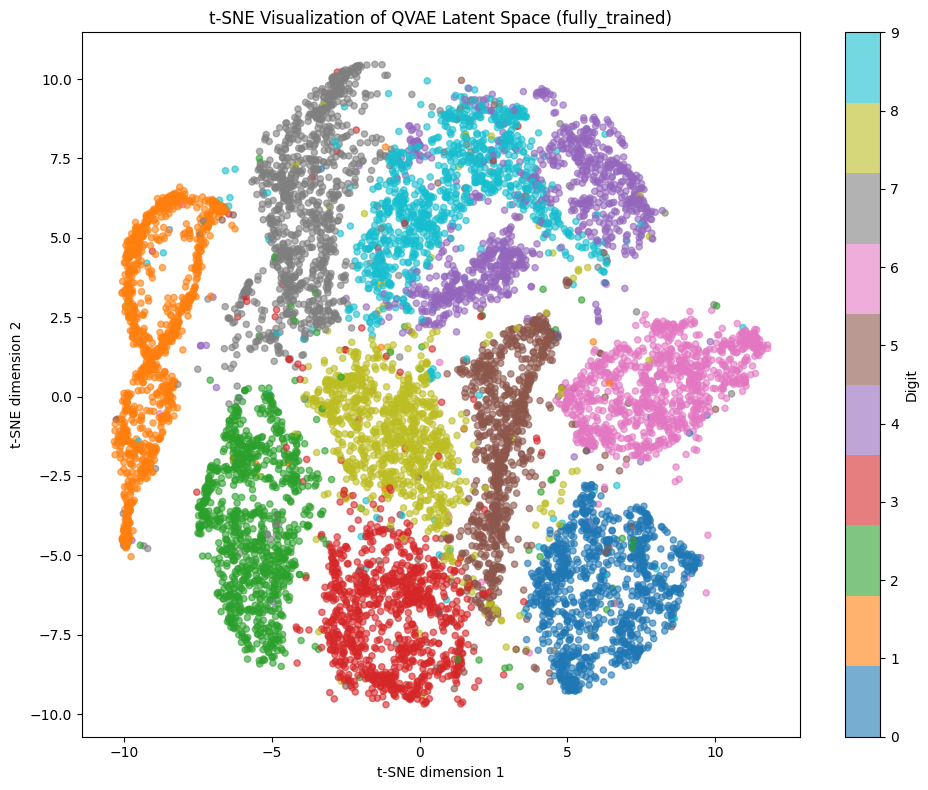

Statistical analysis...
Statistical description per label:
        dim_0                                                              \
        count      mean       std       min       25%       50%       75%   
label                                                                       
0       980.0  0.299574  0.363239  0.000273  0.039453  0.102543  0.677053   
1      1135.0  0.202144  0.288278  0.000220  0.033564  0.081807  0.191981   
2      1032.0  0.577331  0.407473  0.000221  0.096260  0.830026  0.948332   
3      1010.0  0.361576  0.383453  0.000147  0.049126  0.136701  0.837160   
4       982.0  0.264918  0.340711  0.000169  0.033655  0.094523  0.297913   
5       892.0  0.244519  0.328115  0.000260  0.033490  0.094516  0.241886   
6       958.0  0.226127  0.311380  0.000106  0.034410  0.089228  0.209814   
7      1028.0  0.105818  0.134040  0.000201  0.024938  0.065612  0.134927   
8       974.0  0.279129  0.345868  0.000012  0.043848  0.104481  0.341810   
9      1009.0  0.

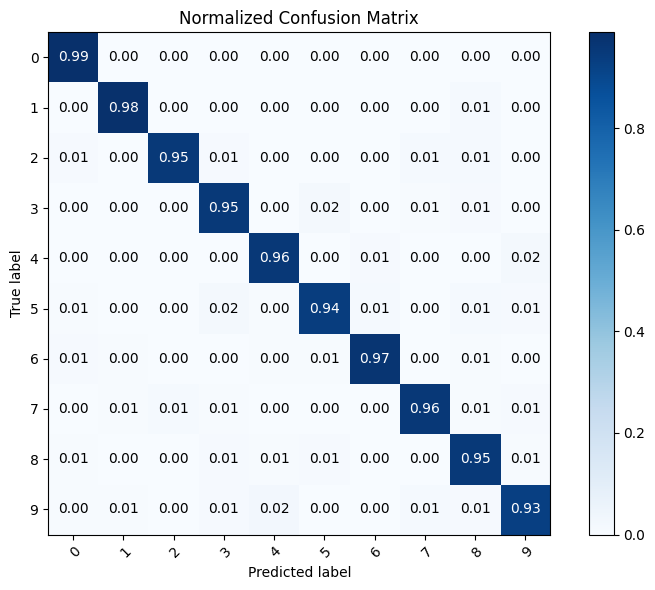

Evaluating final accuracy on test set...
Final Test Accuracy: 95.70%

=== 运行完成 ===
所有结果已保存到: ./models/QVAE_classifier
最终t-SNE: ./models/QVAE_classifier/QVAE_final_t-SNE_epochs_20.png
最终confusion matrix: ./models/QVAE_classifier/QVAE_final_confusion_matrix_epochs_20.png


In [4]:
# ============ 主流程 ============
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    smoke_test = False

    # 初始化Q-VAE参数
    input_dim = 784
    hidden_dim = 512
    latent_dim = 256
    num_var1 = 128
    num_var2 = 128
    dist_beta = 10
    batch_size = 256
    epochs = 2 if smoke_test else 20
    lr = 1e-3
    kl_beta = 0.000001

    # 初始化MLP参数
    mlp_epochs = 100
    mlp_lr = 1e-3
    mlp_batch_size = 64

    # 数据加载
    train_loader, test_loader = setup_data_loaders(
        root = '../../data',
        download = False,
        batch_size =batch_size,
        use_cuda = False  # 如果系统有GPU且已安装CUDA版本
    )
    
    # 1. 训练Q-VAE
    print("Training Q-VAE...")
    qvae = train_qvae(
        device = device,
        train_loader = train_loader,
        test_loader = test_loader,
        input_dim = input_dim, 
        hidden_dim = hidden_dim,
        latent_dim = latent_dim, # latent_dim = num_visible + num_hidden
        num_var1 = num_var1,
        num_var2 = num_var2,
        dist_beta = dist_beta,
        batch_size=batch_size,
        epochs=epochs,
        lr=lr,
        kl_beta = kl_beta
    )
    
    # 2. 从Q-VAE提取潜变量特征zeta
    print("Extracting latent features from Q-VAE...")
    train_features, train_labels = extract_qvae_latent_features(
        qvae, train_loader
    )
    
    # 3. 训练MLP分类器（与经典VAE相同）
    print("Training MLP classifier on Q-VAE latent features...")
    classifier, accuracy = train_mlp_classifier(
        train_features, train_labels,
        epochs=mlp_epochs,
        lr=mlp_lr,
        batch_size=mlp_batch_size,
    )

    # 4. 结果可视化
    print("\nRunning t-SNE visualization...")
    final_tsne_path = os.path.join(save_path, f'QVAE_final_t-SNE_epochs_{epochs}.png')
    df_tsne_final, final_save_path = t_SNE(
        test_loader, 
        qvae, 
        epochs=epochs,
        save_path=final_tsne_path,
        show=True
    )

    print("Statistical analysis...")
    df_stats = describe_statistic_per_label(test_loader, qvae)
    
    print("Confusion matrix...")
    final_cm_path = os.path.join(save_path, f'QVAE_final_confusion_matrix_epochs_{epochs}.png')
    cm = show_confusion_matrix(
        test_loader, 
        qvae, 
        classifier, 
        device,
        save_path=final_cm_path,
        show=True
    )    # 传递qvae和classifier
    
    # 5. 在测试集上评估最终准确率
    print("Evaluating final accuracy on test set...")
    test_features, test_labels = extract_qvae_latent_features(qvae, test_loader)
    
    test_dataset_features = TensorDataset(test_features, test_labels)
    test_loader_features = DataLoader(test_dataset_features, batch_size=mlp_batch_size, shuffle=False)
    
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader_features:
            data, target = data.to(device), target.to(device)
            outputs = classifier(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Final Test Accuracy: {test_accuracy:.2f}%')

    print(f"\n=== 运行完成 ===")
    print(f"所有结果已保存到: {save_path}")
    print(f"最终t-SNE: {final_tsne_path}")
    print(f"最终confusion matrix: {final_cm_path}")